<a href="https://colab.research.google.com/github/apitongcm/Research-Machine-Learning/blob/main/Indoor_Air_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iloilo City (University) - Indoor Air Quality Classification

In [1]:
#import libraries
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


Data Extraction from CSV file dataset captured by sensors

In [2]:
#due to confidentiality of dataset I will not include it here.
#conversion from .xlsx --> .csv
sheet_url = "https://docs.google.com/spreadsheets/d/XXXXXXXXXX"

df = pd.read_csv(sheet_url)

#validation that dataset is working.
print(df.shape)
print(df.columns)
df.head()

(98798, 8)
Index(['transID', 'date_time', 'stationID', 'tvoc', 'eCO2', 'humidity',
       'temperature', 'dustDensity'],
      dtype='object')


,transID,date_time,stationID,tvoc,eCO2,humidity,temperature,dustDensity
0,37,5/30/24 9:42,RM101,0.0,400.0,83,27,0
1,38,5/30/24 9:47,RM101,0.0,414.0,77,29,15
2,39,5/30/24 9:59,RM101,0.0,450.0,74,30,15
3,40,5/30/24 10:04,RM101,0.0,436.0,70,31,14
4,41,5/30/24 10:09,RM101,0.0,400.0,70,31,16


Data Filtering and Cleaning

In [3]:
features = ["tvoc", "eCO2", "humidity", "temperature", "dustDensity"]

# Define numeric constraints for all sensor fields
valid_df = df[
    (df["tvoc"].between(0, 9999.99, inclusive="neither")) &
    (df["eCO2"].between(0, 9999.99, inclusive="neither")) &
    (df["humidity"].between(0, 9999.99, inclusive="neither")) &
    (df["temperature"].between(0, 9999.99, inclusive="neither")) &
    (df["dustDensity"].between(0, 9999.99, inclusive="neither"))
].copy()

X = valid_df[features].astype(float)
print("Rows after cleaning: ", X.shape[0])

Rows after cleaning:  24065


Scaling of Features (K-Means and PCA Fairness)

In [4]:
#standardization
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

#scaled Dataframe
X_scaled_df = pd.DataFrame(X_scaled, columns = features, index=X.index)

X_scaled_df

,tvoc,eCO2,humidity,temperature,dustDensity
6,-0.437766,-0.533453,0.340089,0.354709,-1.272401
8,-0.393305,-0.502788,-0.393990,1.050056,1.071134
10,-0.367033,-0.473827,-0.944549,1.050056,-0.100634
11,-0.432714,-0.566673,-0.761030,1.745402,-0.393576
12,-0.387242,-0.493418,-0.944549,1.745402,-0.686517
...,...,...,...,...,...
98598,-0.118457,0.039809,-1.678629,1.050056,0.192308
98599,-0.256891,-0.002782,-1.678629,1.050056,0.485250
98600,-0.328635,-0.041113,-1.495109,1.050056,0.485250
98601,-0.467070,-0.151847,-1.311589,1.050056,0.485250


Elbow Method - run K-Means for different cluster(K) and plot inertia (sum of squared distances).

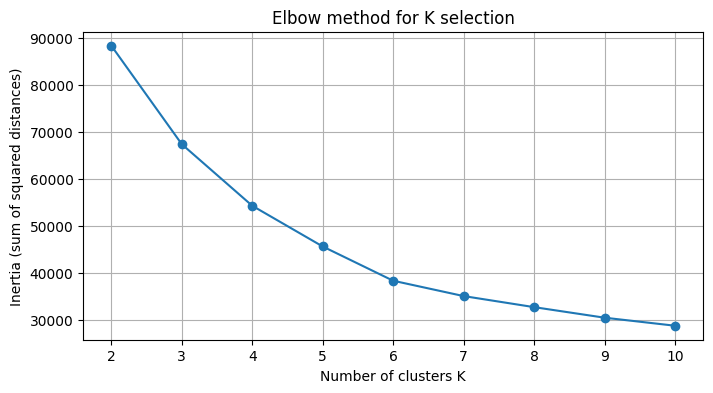

In [5]:
inertias = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

#ploting
plt.figure(figsize=(8,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow method for K selection")
plt.grid(True)
plt.show()

Train K-Means and Add Cluster columns

In [6]:
#Based on Elbow Method
selected_K = 4

kmeans = KMeans(n_clusters=selected_K, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(X_scaled)
valid_df["KMeans_Cluster"] = cluster_labels

#Adding original Dataframe
valid_df = valid_df.copy()
valid_df["Cluster"] = cluster_labels
valid_df["Cluster"] = valid_df["Cluster"].astype(int)

#Validation (peek)
print(valid_df["Cluster"].value_counts().sort_index())
valid_df.head()

Cluster
0     2943
1    13144
2       68
3     7910
Name: count, dtype: int64


,transID,date_time,stationID,tvoc,eCO2,humidity,temperature,dustDensity,KMeans_Cluster,Cluster
6,43,5/30/24 10:30,RM101,66.0,488.0,69,32,12,1,1
8,45,5/30/24 10:35,RM101,110.0,524.0,65,33,20,1,1
10,47,5/30/24 10:48,RM101,136.0,558.0,62,33,16,1,1
11,48,5/30/24 10:53,RM101,71.0,449.0,63,34,15,1,1
12,49,5/30/24 10:59,RM101,116.0,535.0,62,34,14,1,1


PCA 2D visualization (clusters) - PCA compresses your 5D data to 2D

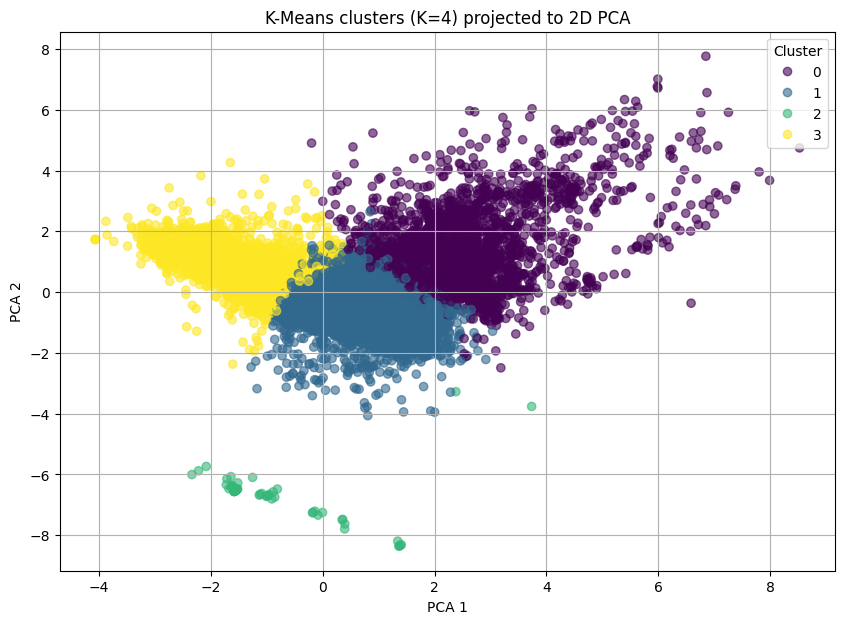

In [7]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

valid_df["PCA1"] = X_pca[:, 0]
valid_df["PCA2"] = X_pca[:, 1]

# Plot clusters in PCA plane
plt.figure(figsize=(10,7))
scatter = plt.scatter(valid_df["PCA1"], valid_df["PCA2"], c=valid_df["Cluster"], alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"K-Means clusters (K={selected_K}) projected to 2D PCA")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)

Interpretation of Clusters - summary statistics

In [8]:
cluster_summary = valid_df.groupby("Cluster")[features].agg(["mean", "std", "count"])

cluster_means = valid_df.groupby("Cluster")[features].mean().round(2)
cluster_counts = valid_df["Cluster"].value_counts().sort_index()

print("Cluster counts:\n", cluster_counts)
print("\nCluster means:\n", cluster_means)
print("\nCluster summary:\n", cluster_summary)

Cluster counts:
 Cluster
0     2943
1    13144
2       68
3     7910
Name: count, dtype: int64

Cluster means:
             tvoc     eCO2  humidity  temperature  dustDensity
Cluster                                                      
0        2224.99  3680.05     64.03        32.61        15.88
1         294.92   846.01     64.41        32.14        16.73
2         217.78   582.19     71.66        29.91        63.81
3         199.07   609.96     72.81        30.01        15.47

Cluster summary:
                 tvoc                             eCO2                      \
                mean          std  count         mean          std  count   
Cluster                                                                     
0        2224.986069  1926.834810   2943  3680.049269  1404.661353   2943   
1         294.915551   377.788992  13144   846.014075   582.039022  13144   
2         217.779412   627.892253     68   582.191176   626.249801     68   
3         199.069532   300.070885  